In [1]:
# Install and import TF2
!pip install -q tensorflow==2.0.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 86.3MB 69kB/s 
     |████████████████████████████████| 450kB 43.1MB/s 
     |████████████████████████████████| 3.8MB 37.8MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
2.0.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D,MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [4]:
# unfortunately this URL doesn't work with pd.read_csv
!wget https://lazyprogrammer.me/course_files/spam.csv

--2020-01-04 23:08:52--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:30::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K   739KB/s    in 0.7s    

2020-01-04 23:08:54 (739 KB/s) - ‘spam.csv’ saved [503663/503663]



In [0]:
# read with pandas using correct encoding
df = pd.read_csv('spam.csv',encoding='ISO-8859-1')

In [0]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis=1)

In [0]:
# rename columns to sthing better
df.columns = ['labels','data']

In [0]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [0]:
# split up the data
df_train,df_test,Ytrain,Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [0]:
# convert sentences to sequences
MAX_VOCAB_SIZE=20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [11]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7204 unique tokens.


In [12]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:',data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 121)


In [13]:
data_test = pad_sequences(sequences_test,maxlen=T)
print('Shape of data test tensor:',data_test.shape)

Shape of data test tensor: (1839, 121)


In [0]:
# create the model

# We get to choose embeding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V+1) x D.
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V+1.

i = Input(shape=(T,))
x = Embedding(V+1,D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

In [15]:
# Compile and fit
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
print('Training model....')
r=model.fit(
    data_train,
    Ytrain,
    epochs=5,
    validation_data=(data_test,Ytest)
)

Training model....
Train on 3733 samples, validate on 1839 samples
Epoch 1/5
3733/3733 [==============================] - 3s 869us/sample - loss: 0.4136 - accuracy: 0.8628 - val_loss: 0.3790 - val_accuracy: 0.8581
Epoch 2/5
3733/3733 [==============================] - 2s 558us/sample - loss: 0.3099 - accuracy: 0.8698 - val_loss: 0.2921 - val_accuracy: 0.8581
Epoch 3/5
3733/3733 [==============================] - 2s 601us/sample - loss: 0.0942 - accuracy: 0.9671 - val_loss: 0.1253 - val_accuracy: 0.9695
Epoch 4/5
3733/3733 [==============================] - 2s 583us/sample - loss: 0.0309 - accuracy: 0.9906 - val_loss: 0.1091 - val_accuracy: 0.9744
Epoch 5/5
3733/3733 [==============================] - 2s 586us/sample - loss: 0.0159 - accuracy: 0.9960 - val_loss: 0.1101 - val_accuracy: 0.9766


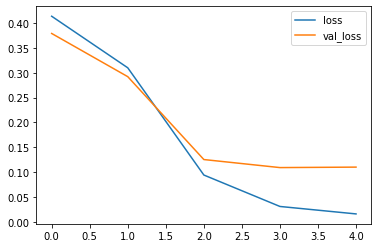

In [16]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

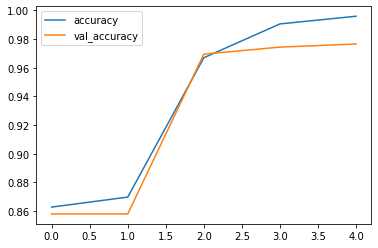

In [17]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()